In [1]:
import mph
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load client
client = mph.start(cores=1)
client.clear()

In [3]:
# filepath to COMSOL model to load
directory = "D:\COMSOL\Leo\Results"
fp = os.path.join(directory, "SiN_Membrane_wMetalPad_BoundaryLayerAndMapped.mph")

# load model
model = client.load(fp)

In [4]:
# Access Java API directly
java_model = model.java

mesh_tag = "mesh6"  # obtain via COMSOL
mesh = java_model.component("comp1").mesh(mesh_tag)  # load the mesh

# load data set
dataset_tag = "dset9"
data_set_spec = java_model.result().dataset(dataset_tag)

In [5]:
# We want to set up an evaluation function, following MPh syntax.
# MPH mapping 'evaluations':  'self.model.java.result().numerical()'

# To create an evaluation object, use create(<tag>, "Eval") (or EvalGlobal for global evaluation)
extract_w = java_model.result().numerical().create("w_derivs_arrs", "Eval")

# set properties of evaluation object - page 578 COMSOL docs
extract_w.set("data", "dset9")  # data set used for evaluation
extract_w.set("unit", "um")  # set units for evaluation
# extract_w.set("expr", "w")  # expression to evaluate

<java object 'com.comsol.model.impl.NumericalFeatureImpl'>

In [6]:
# Next, we want to calculate derivatives
extract_w.set("expr", ["w", "dtang(dtang(w, x), x)", "dtang(dtang(w, y), y)", "dtang(w, x)"])

# calling getData() returns a an array where array[i, j, k] is the expression with index i evaluated
# using solution number j and coordinates data point k, i.e. [expression][solnum][coordinates]
# We can also use getData(<expressionIndex>) if we eg. only care about expression 0.

<java object 'com.comsol.model.impl.NumericalFeatureImpl'>

In [79]:
extract_w.set("outersolnum", "12")  # osn to set
osn = extract_w.getString("outersolnum")

print(osn)

12


In [80]:
# get results data
displacement_field_z = np.array(extract_w.getData(0))[0] # has same number of elements as the mesh stuff
deriv_xx = np.array(extract_w.getData(1))[0]
deriv_yy = np.array(extract_w.getData(2))[0]
deriv_x = np.array(extract_w.getData(3))[0]

print(displacement_field_z.shape)

(191921,)


(191921,)


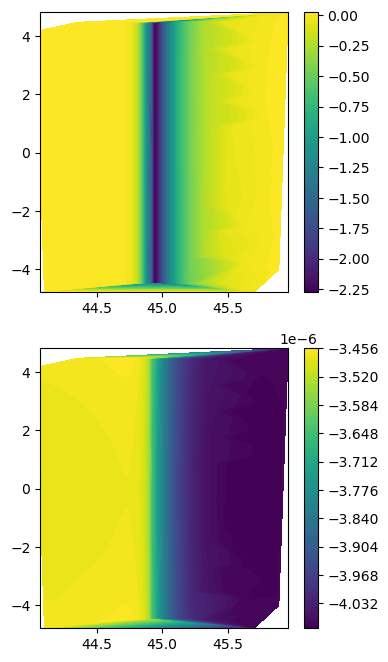

In [86]:
XX, YY, ZZ = np.array(extract_w.getCoordinates())

mask_x = np.logical_and(XX < 46, XX > 44)
mask_y = np.logical_and(YY > -5, YY < 5)
mask_z = np.logical_and(ZZ < 0.05, ZZ > 0)

mf = np.logical_and(mask_x, mask_y)
mf = np.logical_and(mf, mask_z)

print(mf.shape)

fig_heatmap, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(4, 8))

triplot1 = ax1.tricontourf(XX[mf], YY[mf], deriv_xx[mf], levels=100)
fig_heatmap.colorbar(triplot1, ax=ax1)

triplot2 = ax2.tricontourf(XX[mf], YY[mf], deriv_x[mf], levels=100)
fig_heatmap.colorbar(triplot2, ax=ax2)

plt.show()

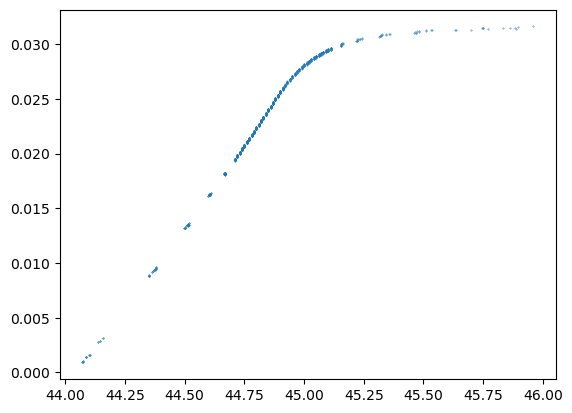

In [87]:
plt.scatter(XX[mf], ZZ[mf], s=0.1)
# plt.ylim(-0.25, 0.25)

In [60]:
# We calculate the total energy for the fundamental mode. 
# For that, we already have an evaluation node in the COMSOL file. Its tag is int1

int_volume = java_model.result().numerical("int1")  # load evaluation node with tag
sol_number = 0

# check if the correct eval expression is loaded
print(int_volume.getString("expr"))

# Just retrieve data, without re-computing it (even though it *should recompute it*)
int_volume_real = np.squeeze(np.array(int_volume.getReal()))[sol_number]
print(int_volume_real)

energy_total = int_volume_real[sol_number]
# print(energy_total)

# Compare with method computeResult()
# int_volume_compute = np.squeeze(np.array(int_volume.computeResult()))
# print(int_volume_compute)

solid.rho*2*(pi*solid.freq)^2*w^2, solid.rho * 2 * (pi * solid.freq)^2 * w^2 / (4.2398E-10 / 2)^2, solid.Wk, w^2 / (4.2398E-10 / 2)^2
[2.28956451e-17 6.34589067e-17 6.34410642e-17 1.19648802e-16
 1.10797957e-16 1.26643516e-16 9.71587511e-17 9.69266395e-17
 2.05795467e-16 1.51064078e-16 2.27092738e-16 2.26813885e-16]


In [54]:
# get regular grid - distance 1 um
x_np = np.linspace(44.5, 45.5, 101, endpoint=True)
y_np = np.array([0.] * 101)
# x_np = np.hstack([seq_geom_neg, seq_geom_pos])
# x_np = np.hstack([seq_outer_neg, seq_outer_pos])

# x_np, y_np = np.meshgrid(x_np, y_np) # extend to grid

# x_np, y_np = x_np.flatten(), y_np.flatten()  # flatten grid - 301^2 entries

z_np = np.array([0.] * len(x_np))

grid_interp = np.array([x_np, y_np, z_np])
print(grid_interp.shape)

(3, 101)


(47,)


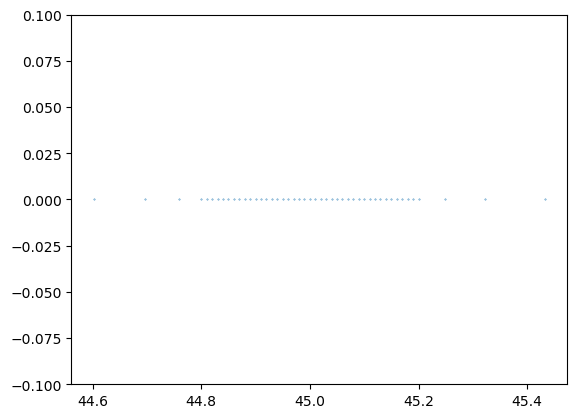

In [88]:
xtm, ytm, ztm = np.array(mesh.getVertex())

xm = np.logical_and(xtm > 44.5, xtm < 45.5)
ym = np.logical_and(ytm < 0.25, ytm > -0.25)
zm = ztm == 0

tm = np.logical_and(xm, ym)
tm = np.logical_and(tm, zm)

xtm, ytm, ztm = xtm[tm], ytm[tm], ztm[tm]

plt.scatter(xtm, ytm, s=0.1)
plt.ylim(-0.1, 0.1)

print(ytm.shape)

In [90]:
grid_interp = np.array([xtm, ytm, ztm])

In [89]:
# Interpolate data set to evaluate displacement field using mesh coordinates

mesh_vertices_java = mesh.getVertex()

# Choose selection for solution data set - see COMSOL Docs on Interp method
dset_tag = "dset9"  # dset7 has a surface selection - prev. dset5
tag_itp = "mesh_interp"
tag_grid = "grid_interp"
interpol =  java_model.result().numerical().create(tag_itp, "Interp")
interpol.set("data", dset_tag)
interpol.set("expr", ["w", "dtang(dtang(w, x), x)", "dtang(w, x)", "dtang(dtang(w, x), y)"])

<java object 'com.comsol.model.impl.NumericalFeatureImpl'>

In [91]:
# interpol.setInterpolationCoordinates(mesh_vertices_java) # expects Java type
interpol.setInterpolationCoordinates(grid_interp) # expects Java type

In [115]:
derivs_full_xx = []
derivs_full_x = []

for ii in range(1, 13):
    idx = str(ii)
    interpol.set("outersolnum", idx)
    
    # get results data
    displacement_field_z = np.array(interpol.getData(0))[0] # has same number of elements as the mesh stuff
    deriv_xx_itp = np.array(interpol.getData(1))[0]
    deriv_x_itp = np.array(interpol.getData(2))[0]
    deriv_xy_itp = np.array(interpol.getData(3))[0]
    
    derivs_full_xx.append(deriv_xx_itp)
    derivs_full_x.append(deriv_x_itp)

print(displacement_field_z.shape)

(47,)


Text(0.5, 1.0, 'Second derivative X [1/m]')

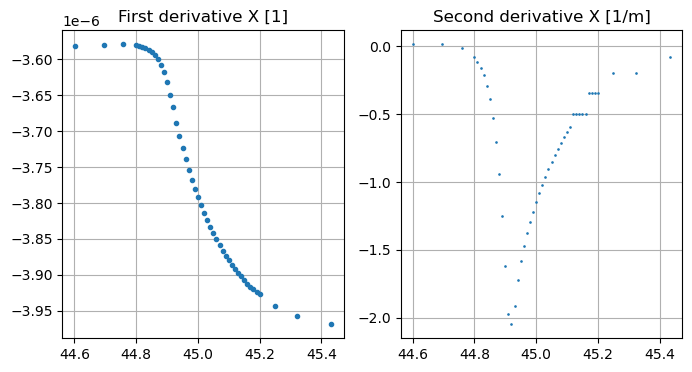

In [102]:
plot_range = np.copy(xtm)

fig_linear, (ax1, ax2) =  plt.subplots(ncols=2, figsize = (8, 4))

ax1.grid()
ax2.grid()
ax1.plot(plot_range, derivs_full_x[-1], ".")
ax2.plot(plot_range, derivs_full_xx[-1], ".", ms=1.8)
ax1.set_title("First derivative X [1]")
ax2.set_title("Second derivative X [1/m]")

In [114]:
print(len(derivs_full_xx))

9


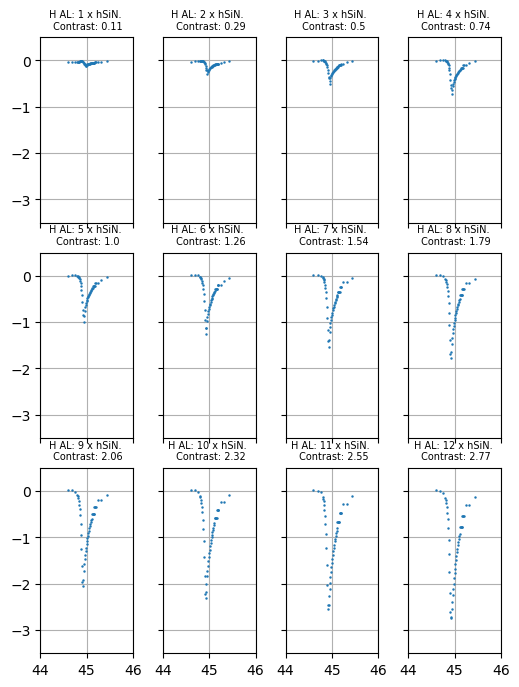

In [128]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12, 8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 4),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, im, idxx in zip(grid, derivs_full_xx[:12], range(1, 13)):
    # print(im)
    # Iterating over the grid returns the Axes.
    # imm = np.arange(100).reshape((10, 10))
    contrast = np.around((np.amax(im) - np.amin(im)), 2)
    ax.plot(plot_range, im, ".", ms=1.5)
    ax.grid()
    ax.set_ylim(-3.5, 0.5)
    ax.set_xlim(44, 46)
    ax.set_title(f"H AL: {idxx} x hSiN. \n Contrast: {contrast}", fontsize=7)

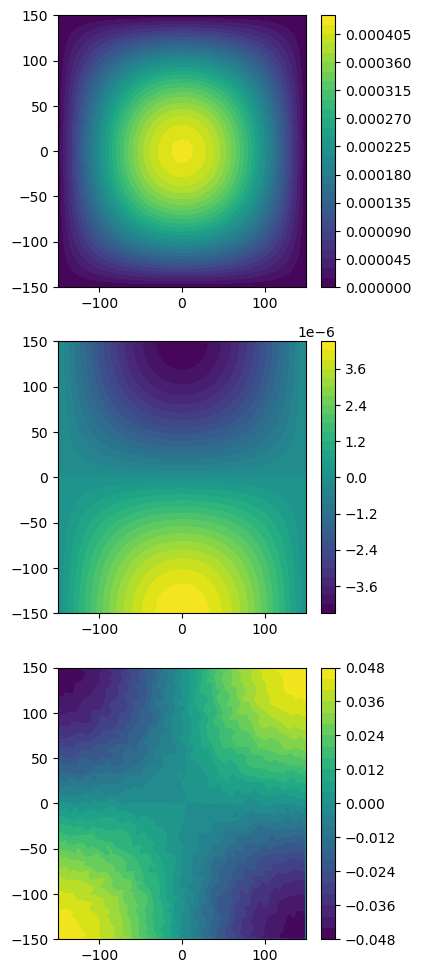

In [51]:
fig_heatmap, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(4, 12))

triplot1 = ax1.tricontourf(x_mask, y_mask, displacement_field_z, levels=30)
fig_heatmap.colorbar(triplot1, ax=ax1)

triplot2 = ax2.tricontourf(x_mask, y_mask, deriv_y, levels=30)
fig_heatmap.colorbar(triplot2, ax=ax2)

triplot3 = ax3.tricontourf(x_mask, y_mask, deriv_xy, levels=30)
fig_heatmap.colorbar(triplot3, ax=ax3)

plt.show()

In [ ]:
# test interpolation coordinates
test_cords = np.array(interpol.getCoordinates())
print(test_cords.shape)

In [ ]:
# Plotting - use triangular plots as simple 3D surface plots require a 2D Z array
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')


# Plot the surface
ax.view_init(elev=20., azim=20.)
ax.plot_trisurf(x_np, y_np, deriv_yy, cmap='viridis', edgecolor='none')

In [10]:
# get Q factor
sumCurvature = (deriv_xx + deriv_yy)

# Parameters
h = 50.0e-9
E1 = 200.0e9
E2 = E1/(5.7e10 * h) # See Figure 2 in Villanueva et al.
nu = 0.27

# Integration element 
dx, dy = 1e-6, 1e-6

1e-06


In [11]:
# Formulas from Yeghishe

dW = np.nansum(sumCurvature**2) * dx * dy * h**3 * np.pi * E2 / (12 * (1 - nu**2))  # SI units

intermed = np.nansum(sumCurvature**2 - 2 * (1 - nu) * (deriv_xx * deriv_yy - deriv_xy ** 2))  # SI units
dW_full = dx * dy * h**3 * np.pi * E2 / (12 * (1 - nu**2)) * intermed

print(dW, dW_full)

2.4617683998705698e-23 5.949438407156385e-23


In [12]:
W =  2.8172456e-17  # calculated in COMSOL

Q = (2*np.pi*W/dW) / 1e6 # no units, number -> divide by 1e6 to get millions
Q_full = (2*np.pi*W/dW_full) / 1e6

print(Q, Q_full)

7.190471760693249 2.9752852200880087
